<a href="https://colab.research.google.com/github/raunaqjabbal/ConditonalGAN/blob/main/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from keras.layers import Layer
from keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

from keras.models import Model
from keras.layers import Reshape
from keras.layers import InputLayer
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2DTranspose
from keras.layers import ReLU
from keras import activations
from keras.layers import Activation
from keras.layers import Normalization
from keras.layers import LeakyReLU
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalAveragePooling2D
from keras.activations import sigmoid
from keras.activations import selu

import imageio
from IPython import display

In [2]:
(X_train,y_train) ,(X_test, y_test)  = tf.keras.datasets.mnist.load_data()
X = np.append(X_train,X_test,axis=0)
y = np.append(y_train,y_test,axis=0)

del X_train,y_train,X_test,y_test

X = X[...,np.newaxis]
# norm_layer = Normalization(mean=(0.5),variance=np.square(0.5))
X = X.astype("float32") / 255.0
# X = (X*2)-1


Z_DIM = 128
DEPTH = len(np.unique(y))
CHANNELS = 1
IMGSIZE = 28
BATCH_SIZE=32

y=tf.one_hot(y,DEPTH)

print(X.shape)    #(None, IMGSIZE, IMGSIZE, CHANNELS)
print(y.shape)    #(None, DEPTH)

11490434/11490434 [==============================] - 1s 0us/step
(70000, 28, 28, 1)
(70000, 10)


## Model Architecture

In [3]:
class Generator(Layer):
    def __init__(self, filters=64, strides=2,kernel_size=3,final_layer=False,**kwargs):
        super(Generator, self).__init__(**kwargs)

        self.filters = filters
        self.strides  =strides
        self.kernel_size= kernel_size
        self.final_layer=final_layer
        self.weight_initer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        self.conv2dt = Conv2DTranspose(filters,kernel_size,strides)
        self.norm= BatchNormalization()
        if self.final_layer:
          self.activ = Activation(sigmoid)
        else:  
          self.activ = Activation(selu)
          

    def call(self, x):
        x = self.conv2dt(x)
        if not self.final_layer:
          x = self.norm(x)
        x = self.activ(x)
        return x

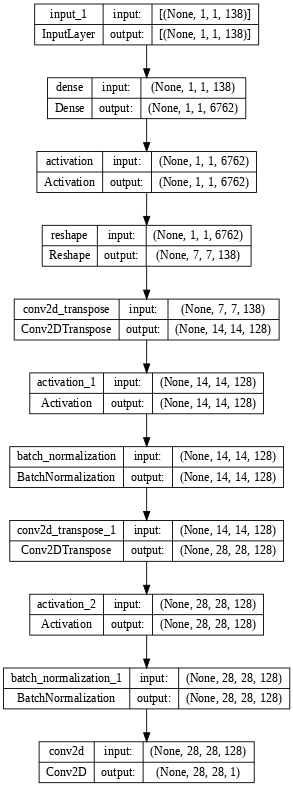

In [4]:
input = Input(shape=(1,1,DEPTH+Z_DIM))
# x = Flatten()(input)
# x = Dense(1 * 1 * (DEPTH+Z_DIM))(x)
# x = Activation(selu)(x)
# x = Reshape((1, 1, DEPTH+Z_DIM))(x)


# x = Generator(256)(x)
# # x = Flatten()(x)
# # x = Dense(3 * 3 * (256))(x)
# # x = LeakyReLU(alpha=0.2)(x)
# # x = Reshape((3, 3, 256))(x)

# x = Generator(128, kernel_size=4, strides=1)(x)
# # x = Flatten()(x)
# # x = Dense(6 * 6 * (128))(x)
# # x = LeakyReLU(alpha=0.2)(x)
# # x = Reshape((6, 6, 128))(x)

# x = Generator(64) (x)
# x = Flatten()(x)
# x = Dense(13 * 13 * (64))(x)
# x = Activation(selu)(x)
# x = Reshape((13, 13, 64))(x)
# x = Generator(1,kernel_size=4, final_layer=True)(x)


x = Dense(7 * 7 * (DEPTH+Z_DIM))(input)
x = Activation(selu)(x)
x = Reshape((7, 7, DEPTH+Z_DIM))(x)
x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = Activation(selu)(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = Activation(selu)(x)
x = BatchNormalization()(x)
x = Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)

Activation(selu)

generator= Model(inputs=input, outputs=x)


# generator.summary()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, expand_nested=True)

In [5]:
class Discriminator(Layer):
    def __init__(self, filters=64, strides=2,kernel_size=4,final_layer=False,**kwargs):
        super(Discriminator, self).__init__(**kwargs)

        self.filters = filters
        self.strides  =strides
        self.kernel_size= kernel_size
        self.final_layer=final_layer
        self.weight_initer = tf.random_normal_initializer(mean=0.0, stddev=0.02)

        self.conv2d = Conv2D(filters,kernel_size,strides)
        self.norm= BatchNormalization()
        self.activ = Activation(selu)
        self.flat = Flatten()
          
    def call(self, x):
        x = self.conv2d(x)
        if not self.final_layer:
          x = self.norm(x)
          x = self.activ(x)
        else:
          x = self.flat(x)
        return x

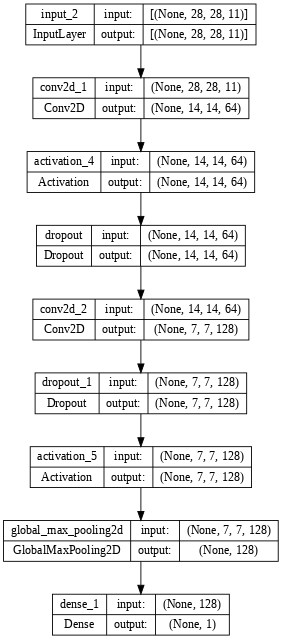

In [6]:
input = Input(shape=(28,28,DEPTH+CHANNELS))
# x = Discriminator(64)(input)
# x = Discriminator(128)(x)
# x = Discriminator(1, final_layer=True)(x)

# x = Discriminator(1, final_layer=True)(input)
# x = Dense(1)(x)


x = Conv2D(64, (5,5), strides=(2, 2), padding="same")(input)
x = Activation(selu)(x)
x = Dropout(0.4)(x)
x = Conv2D(128, (5, 5), strides=(2, 2), padding="same")(x)
x = Dropout(0.4)(x)
x = Activation(selu)(x)
x = GlobalMaxPooling2D()(x)
x = Dense(1)(x)

discriminator = Model(inputs=input, outputs=x)

# discriminator.summary()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64, expand_nested=True)

## Utilities


In [23]:
from torchvision.utils import make_grid
import torch
def plot_results(images, size=8, r=False):
    # display.clear_output(wait=False)
    photos = (images[:size*size,:,:,:CHANNELS])                   # (SIZE*SIZE, IMGSIZE, IMGSIZE, CHANNELS)
    photos = np.transpose(photos, (0, 3, 1, 2))                   # (SIZE*SIZE, CHANNELS, IMGSIZE, IMGSIZE)
    image_grid = make_grid(torch.tensor(photos), nrow=size)       # (CHANNELS, IMGSIZE, IMGSIZE)
    if r:
        return image_grid.permute(1, 2, 0).squeeze()              # (IMGSIZE, IMGSIZE, CHANNELS)
    else:
        plt.imshow(image_grid.permute(1, 2, 0).squeeze(),cmap='gray')
        plt.axis("off")
        plt.show()

def repeatlabels(labels):
    demo = labels[:,None,None,:] 
    demo = tf.repeat(demo, IMGSIZE, axis=1)
    demo = tf.repeat(demo, IMGSIZE, axis=2)
    return demo

## Training Loop

In [28]:
def GAN(gan, X, y, n_epochs=50):
    generator, discriminator = gan
    labels_set = y[:,None,None,:]                                                                   # (None, 1, 1, DEPTH)
    labels_repeated_set = repeatlabels(y)                                                           # (None, IMGSIZE, IMGSIZE, DEPTH)


    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        loss_gen=[]
        loss_dis=[]
        for i in range(X.shape[0]//BATCH_SIZE):                                     
            images = X[i*BATCH_SIZE:(i+1)*BATCH_SIZE,...]                                           # (BATCH, IMGSIZE, IMGSIZE, CHANNELS)
            labels = labels_set[i*BATCH_SIZE:(i+1)*BATCH_SIZE,...]                                  # (BATCH, 1, 1, DEPTH)
            labels_repeated = labels_repeated_set[i*BATCH_SIZE:(i+1)*BATCH_SIZE,...]                # (BATCH, IMGSIZE, IMGSIZE, DEPTH)

###################################################################################################################################################
            
            noise = tf.random.normal(shape=(BATCH_SIZE, Z_DIM))[:,None,None,:]                      # (BATCH, 1, 1, Z_DIM)
            noise = tf.concat([noise, labels], axis=3)                                              # (BATCH, 1, 1, Z_DIM + DEPTH)
            fake_images = generator(noise)                                                          # (BATCH, IMGSIZE, IMGSIZE, CHANNELS)
            
            fake_images = tf.concat([fake_images, labels_repeated], axis=3)                         # (BATCH, IMGSIZE, IMGSIZE, CHANNELS + DEPTH)
            real_images = tf.concat([images, labels_repeated], axis=3)                              # (BATCH, IMGSIZE, IMGSIZE, CHANNELS + DEPTH)
            mixed_images = tf.concat([fake_images, real_images], axis=0)                            # (2 * BATCH, IMGSIZE, IMGSIZE, CHANNELS + DEPTH)
            true_labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)  # (2 * BATCH , 1)

            # discriminator.trainable = True

            with tf.GradientTape() as tape:
                mixed_pred = discriminator(mixed_images)                                            # (2 * BATCH, 1)
                loss = bceloss(true_labels,mixed_pred)                                              # Scalar
                loss_dis.append(loss)
            gradients = tape.gradient(loss,discriminator.trainable_weights)
            optimizer1.apply_gradients(zip(gradients, discriminator.trainable_weights))      

###################################################################################################################################################
            
            # discriminator.trainable = False

            noise = tf.random.normal(shape=(BATCH_SIZE, Z_DIM))[:,None,None,:]                      # (BATCH, 1, 1, Z_DIM)
            noise = tf.concat([noise, labels], axis=3)                                              # (BATCH, 1, 1, Z_DIM + DEPTH)
            with tf.GradientTape() as tape:                                                       
                fake_images = generator(noise)                                                      # (BATCH, IMGSIZE, IMGSIZE, CHANNELS)
                fake_images = tf.concat([fake_images, labels_repeated], axis=3)                     # (BATCH, IMGSIZE, IMGSIZE, CHANNELS + DEPTH)
                fake_pred = discriminator(fake_images)                                              # (BATCH, 1)
                loss = bceloss(tf.zeros_like(fake_pred),fake_pred)                                  # Scalar
                loss_gen.append(loss)
            gradients = tape.gradient(loss,generator.trainable_weights)
            optimizer2.apply_gradients(zip(gradients, generator.trainable_weights))

###################################################################################################################################################

        plt.plot(range(X.shape[0]//BATCH_SIZE), loss_gen,label="Generator Loss")
        plt.plot(range(X.shape[0]//BATCH_SIZE), loss_dis,label="Discriminator Loss")
        plt.legend()
        plt.show()
        plot_results(fake_images) 
    return fake_images

# Training

Epoch 1/20


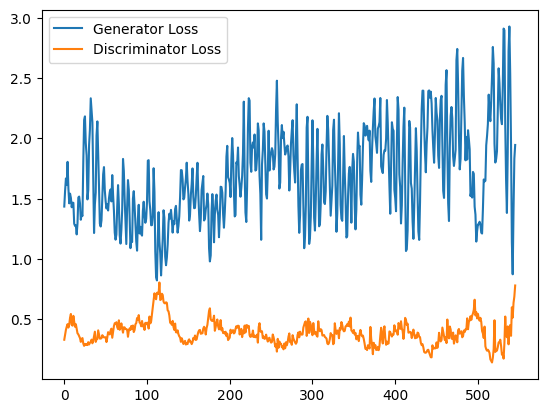

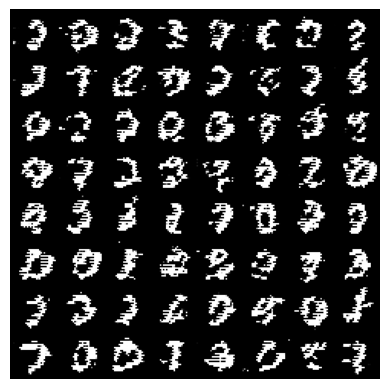

Epoch 2/20


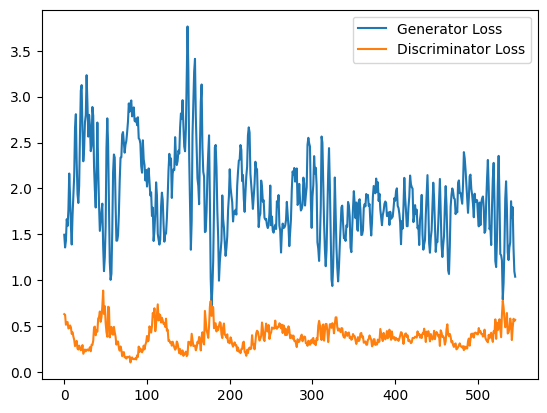

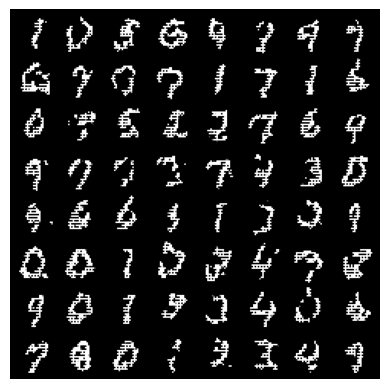

Epoch 3/20


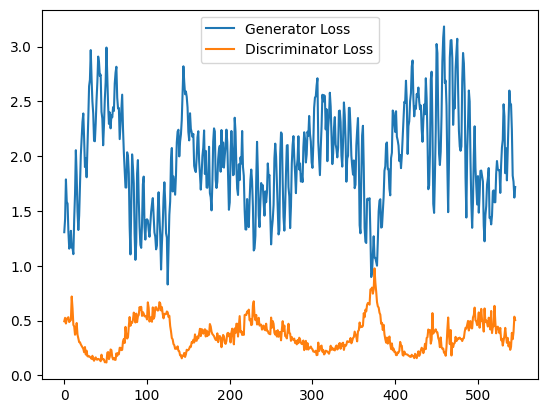

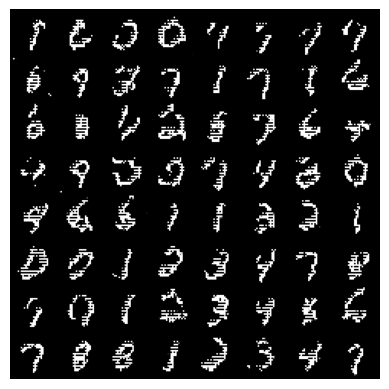

Epoch 4/20


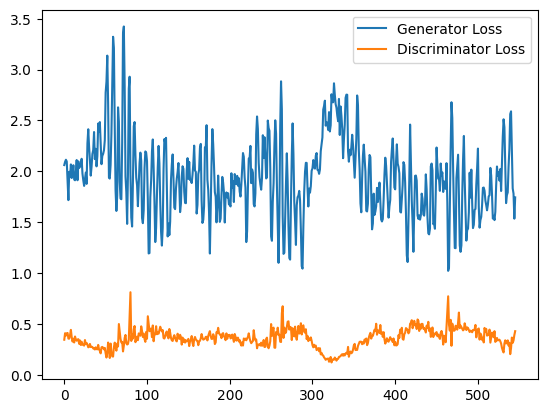

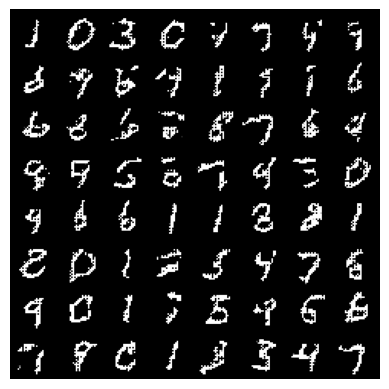

Epoch 5/20


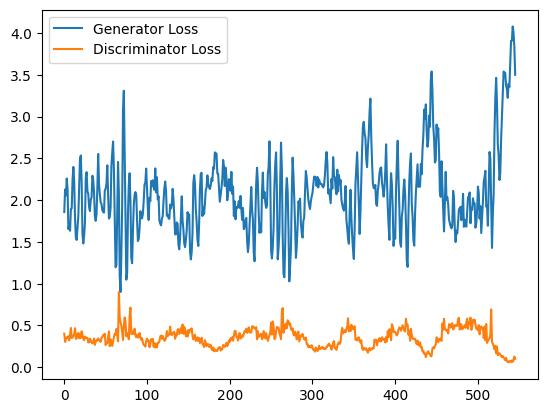

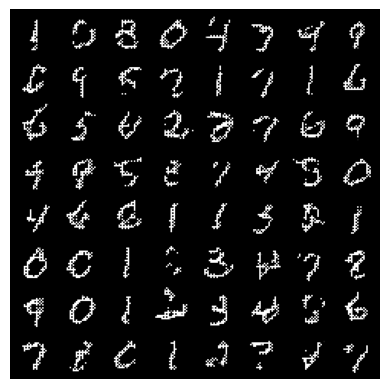

Epoch 6/20


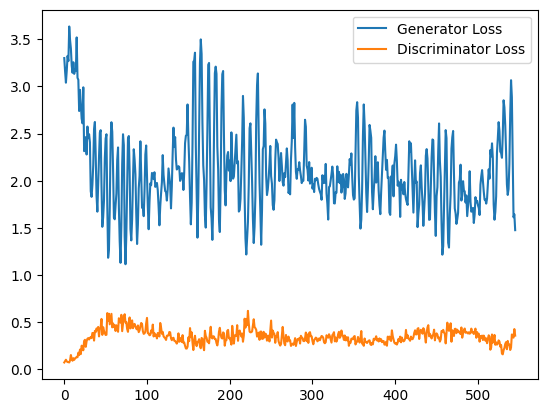

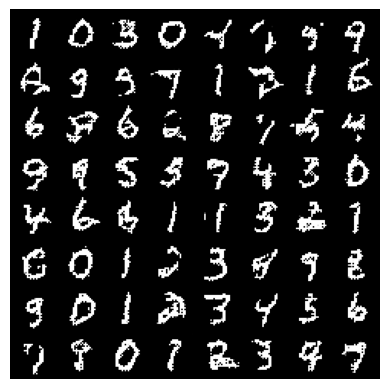

Epoch 7/20


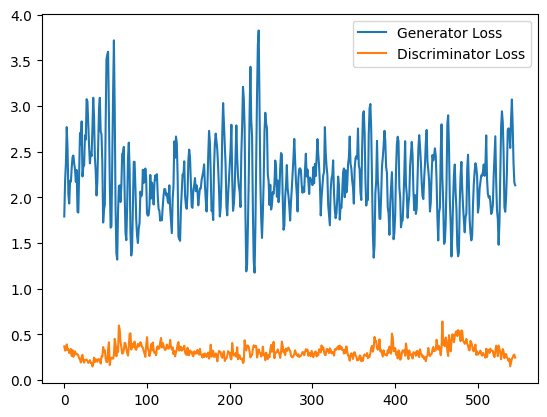

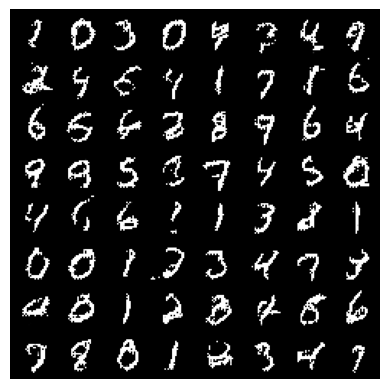

Epoch 8/20


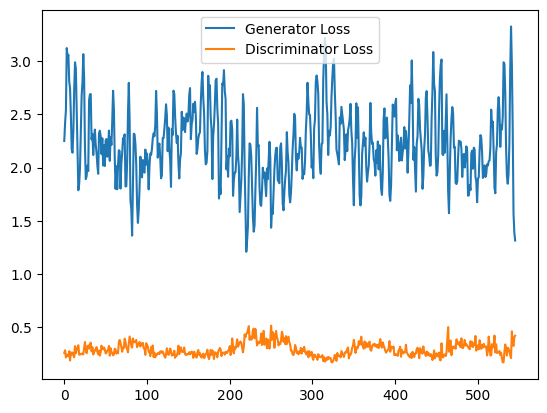

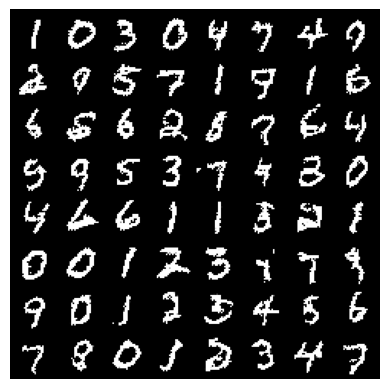

Epoch 9/20


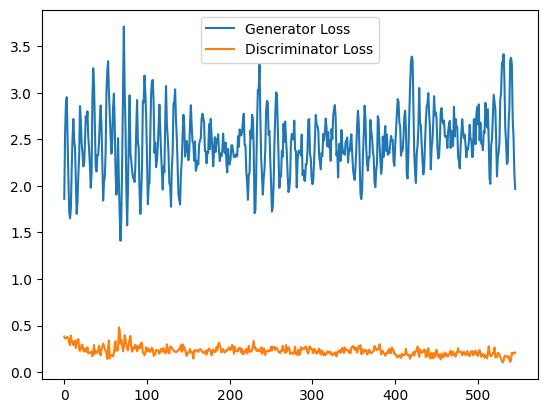

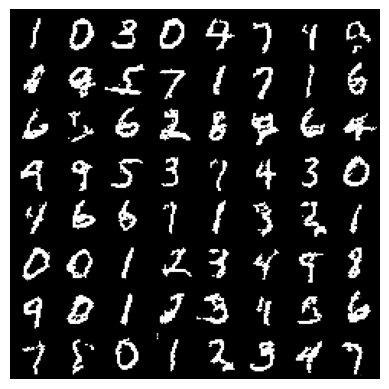

Epoch 10/20


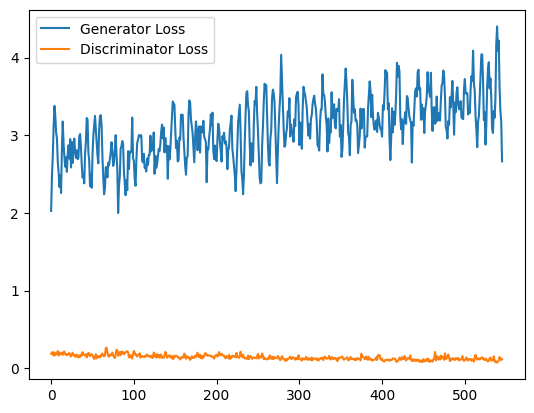

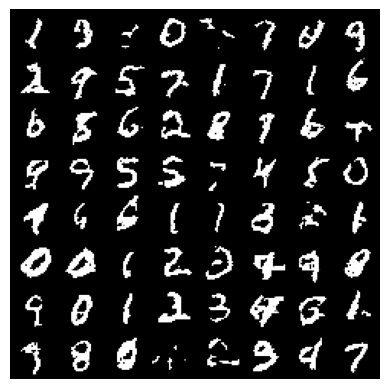

Epoch 11/20


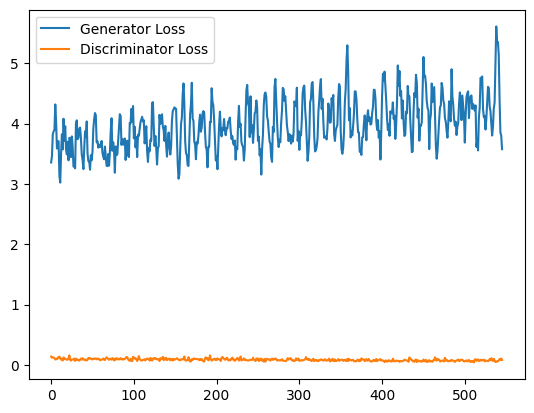

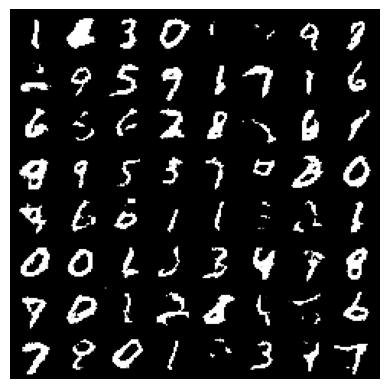

Epoch 12/20


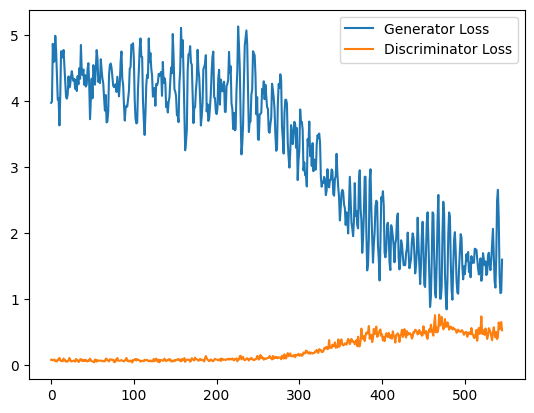

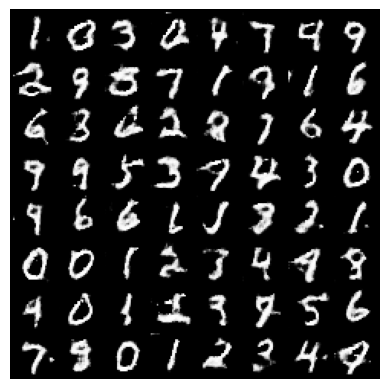

Epoch 13/20


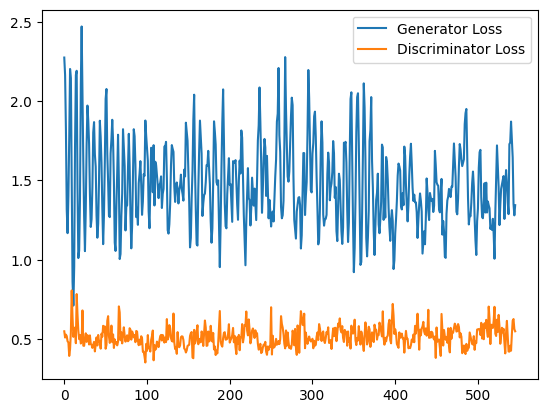

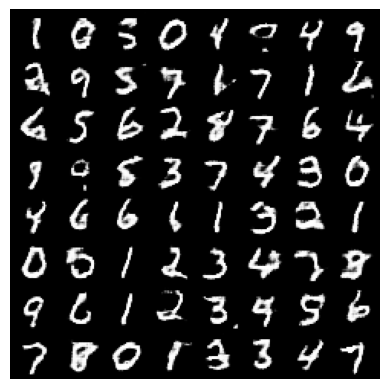

Epoch 14/20


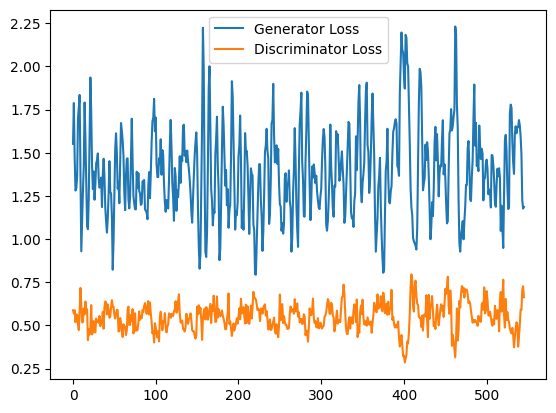

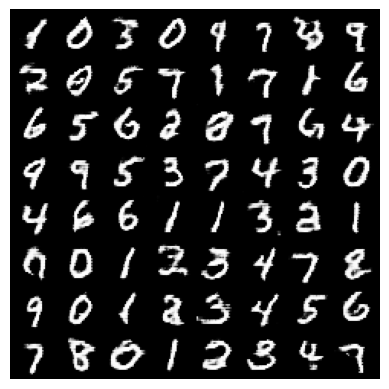

Epoch 15/20


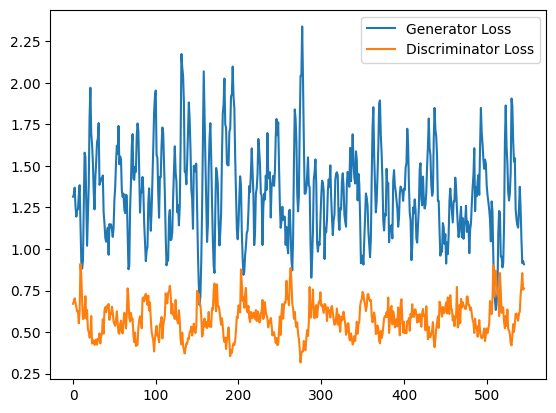

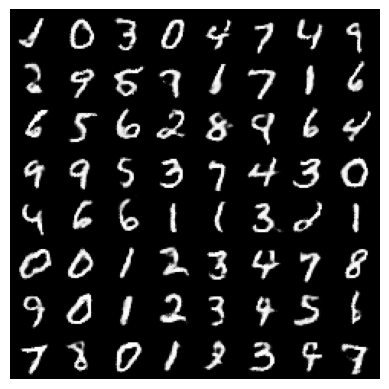

Epoch 16/20


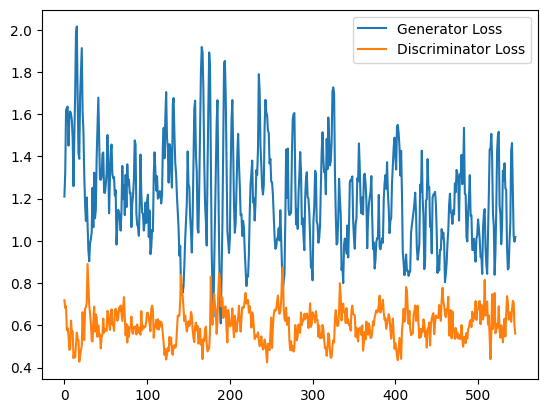

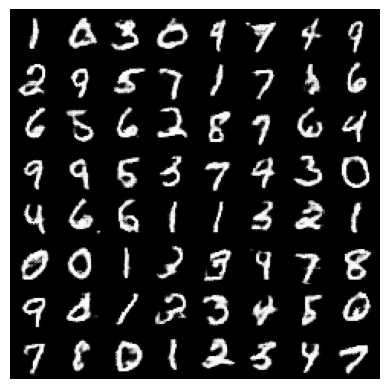

Epoch 17/20


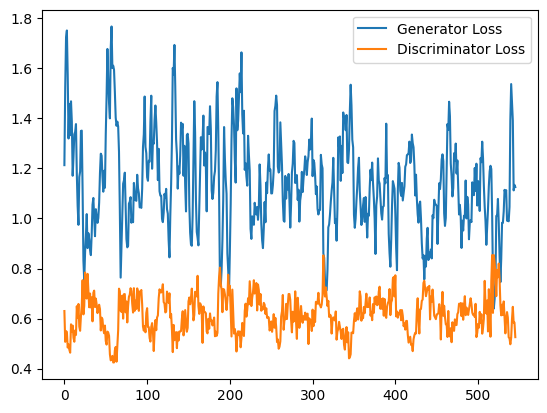

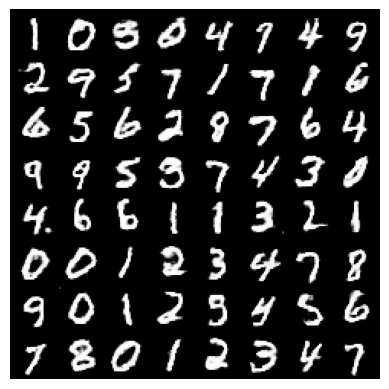

Epoch 18/20


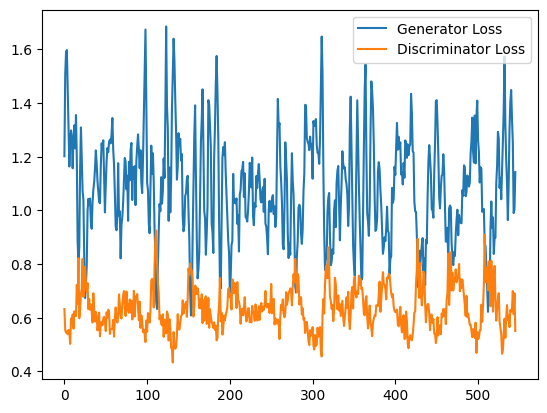

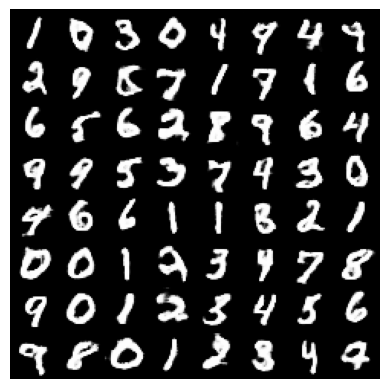

Epoch 19/20


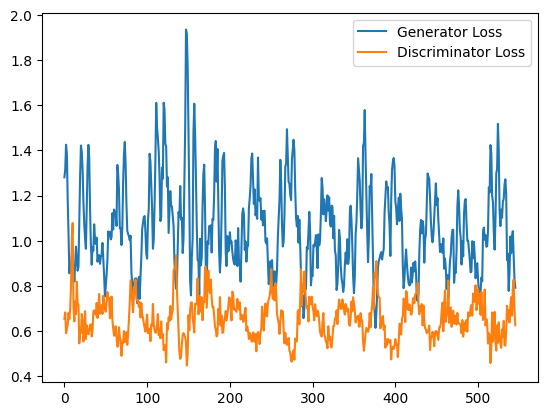

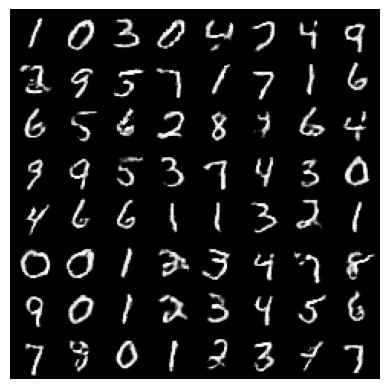

Epoch 20/20


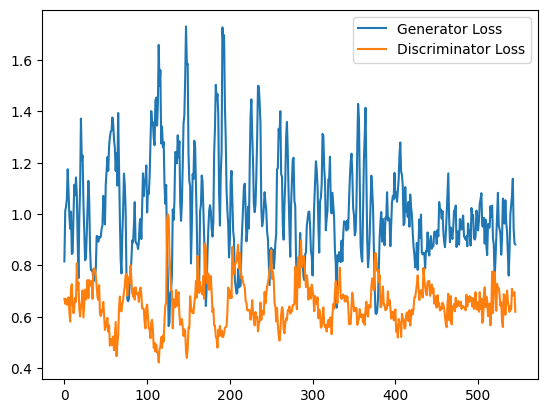

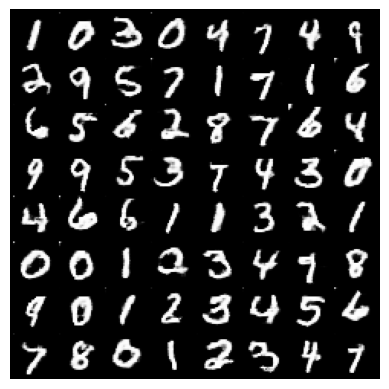

In [ ]:
bceloss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer1 = tf.keras.optimizers.Adam(0.0003)
optimizer2 = tf.keras.optimizers.Adam(0.0003)

EPOCHS = 20
BATCH_SIZE=128

X=X[:X.shape[0]//BATCH_SIZE*BATCH_SIZE,...]
y=y[:y.shape[0]//BATCH_SIZE*BATCH_SIZE,...]

# run the training loop and collect images
fake_images=GAN([generator, discriminator], X, y, EPOCHS)


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# generator.save_weights("/content/drive/MyDrive/gen.h5")
# discriminator.save_weights("/content/drive/MyDrive/dis.h5")

generator.load_weights("/content/drive/MyDrive/gen.h5")
discriminator.load_weights("/content/drive/MyDrive/dis.h5")

## Image Interpolation

2/2 [==============================] - 0s 5ms/step


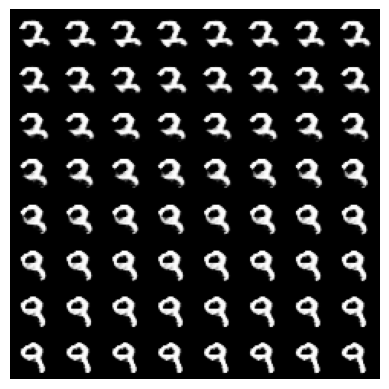

In [20]:
def interpolate_class(first_number, second_number, num=9):
      
    noise = tf.random.normal(shape=(1, Z_DIM))
    noise = np.squeeze([noise]*num)
    
    first_label = tf.one_hot([first_number], DEPTH)
    second_label = tf.one_hot([second_number], DEPTH)

    percent_second_label = tf.linspace(0, 1, num)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    labels = first_label * (1.0 - percent_second_label) + second_label * percent_second_label

    noise_and_labels = tf.concat([noise, labels], 1)[:,None,None,:]
    fake = generator.predict(noise_and_labels)
    return fake

num = 64
start_class = 2
end_class = 9

fake_images = interpolate_class(start_class, end_class, num)
plot_results(fake_images,8)

## Manipulating Class Labels:

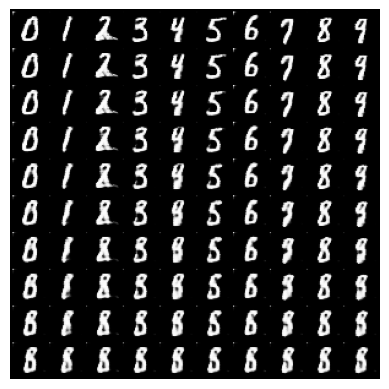

In [ ]:
classlabels = tf.one_hot(range(DEPTH),DEPTH) 
gif_images=[]

inputs=np.array([])

for i in range(10,-1,-1):
    if i==10:
        inputs=classlabels*i/10
    else:
        inputs=np.concatenate((inputs,classlabels*i/10),axis=0)

noise = tf.random.normal(shape=(1, Z_DIM))
noise = np.squeeze([noise]*len(range(10,-1,-1))*10)

noise_and_labels = tf.concat([noise, inputs], 1)[:,None,None,:]
fake = generator(noise_and_labels)
img = plot_results(fake,10)

## Making a GIF:

In [24]:
classlabels = tf.one_hot(range(DEPTH),DEPTH) 
gif_images=[]
for i in range(1000):
  noise = tf.random.normal(shape=(DEPTH, Z_DIM))
  noise_and_labels = tf.concat([noise, classlabels], 1)[:,None,None,:]
  fake = generator(noise_and_labels)
  img = plot_results(fake,DEPTH,r=True)
  img= tf.cast(img*255.,tf.uint8)
  gif_images.append(img)

In [25]:
imageio.mimsave("/content/drive/MyDrive/othergan.gif", gif_images, duration=0.1)